In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D,\
UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
import joblib
from sklearn.neighbors import LocalOutlierFactor
from sklearn import cluster, datasets

import random
import os
import tensorflow as tf
import cv2
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
root_path = "/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset"
path_img_ok = root_path + "/Images/OK/"
path_img_ko = root_path + "/Images/NG/"
path_msk_ok = root_path + "/Masks/OK/"
path_msk_ko = root_path + "/Masks/NG/"
print(path_img_ok)
print(path_img_ko)
print(path_msk_ok)
print(path_msk_ko)

In [ ]:
def print_random_images(img_folder):
    for i in range(5):
        lst = os.listdir(img_folder)
        lst.sort()
        file = lst[i]
        image_path = os.path.join(img_folder, file)
        img = mpimg.imread(image_path)
        ax = plt.subplot(1, 5, i+1)
        ax.title.set_text(file)
        plt.imshow(img)

In [ ]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ok)

In [ ]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ko)

In [ ]:
plt.figure(figsize = (20, 20))
print_random_images(path_msk_ko)

In [ ]:
img_dataset_ok = []
img_dataset_ko = []
msk_dataset_ok = []
msk_dataset_ko = []

In [ ]:
IMG_WIDTH=224
IMG_HEIGHT=224

def create_dataset(img_folder):
    img_data_array = []
    for file in os.listdir(img_folder):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            img_data_array.append(image)
    return img_data_array

def create_dataset_bin(img_folder):
    img_data_array = []
    for file in os.listdir(img_folder):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            image = image.tobytes()
            img_data_array.append(image)
    return img_data_array

In [ ]:
# extract the image array and class name
img_dataset_ok = create_dataset(path_img_ok)
img_dataset_ko = create_dataset(path_img_ko)
msk_dataset_ok = create_dataset(path_msk_ok)
msk_dataset_ko = create_dataset(path_msk_ko)

img_dataset_ok_bin = create_dataset_bin(path_img_ok)
img_dataset_ko_bin = create_dataset_bin(path_img_ko)
msk_dataset_ok_bin = create_dataset_bin(path_msk_ok)
msk_dataset_ko_bin = create_dataset_bin(path_msk_ko)

In [ ]:
print(len(img_dataset_ok))
print(len(img_dataset_ko))
print(len(msk_dataset_ok))
print(len(msk_dataset_ko))

print(len(img_dataset_ok_bin))
print(len(img_dataset_ko_bin))
print(len(msk_dataset_ok_bin))
print(len(msk_dataset_ko_bin))

In [ ]:
plt.figure(figsize = (5, 5))
plt.imshow(img_dataset_ko[0], interpolation='nearest')

In [ ]:
plt.figure(figsize = (5, 5))
img = np.frombuffer(img_dataset_ko_bin[0], dtype=np.float32)
img = np.reshape(img, (224,224,3))
plt.imshow(img, interpolation='nearest')

In [ ]:
df_img_dataset_ok = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ok['image'] = img_dataset_ok_bin
df_img_dataset_ok['label'] = 0
#df_img_dataset_ok

In [ ]:
df_img_dataset_ko = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ko['image'] = img_dataset_ko_bin
df_img_dataset_ko['label'] = 1
#df_img_dataset_ko

In [ ]:
df_msk_dataset_ok = pd.DataFrame(columns = ['image','label'])
df_msk_dataset_ok['image'] = msk_dataset_ok_bin
df_msk_dataset_ok['label'] = 0
#df_msk_dataset_ok

In [ ]:
df_msk_dataset_ko = pd.DataFrame(columns = ['image','label'])
df_msk_dataset_ko['image'] = msk_dataset_ko_bin
df_msk_dataset_ko['label'] = 1
#df_msk_dataset_ok

In [ ]:
df_img_dataset_tot = pd.concat([df_img_dataset_ok,df_img_dataset_ko], ignore_index=True)
df_msk_dataset_tot = pd.concat([df_msk_dataset_ok,df_msk_dataset_ko], ignore_index=True)

In [ ]:
#df_img_dataset_tot

In [ ]:
#df_msk_dataset_tot

In [ ]:
df_img_dataset_tot = df_img_dataset_tot.sample(frac=1).reset_index(drop=True)
df_msk_dataset_tot = df_msk_dataset_tot.sample(frac=1).reset_index(drop=True)

In [ ]:
#df_img_dataset_tot

In [ ]:
#df_msk_dataset_tot

In [ ]:
df_img_dataset_train, df_img_dataset_test = train_test_split(df_img_dataset_tot, test_size=0.97, random_state=25)

In [ ]:
df_img_dataset_val, df_img_dataset_test = train_test_split(df_img_dataset_test, test_size=0.97, random_state=25)

In [ ]:
df_img_dataset_train.groupby("label")['image'].count()

In [ ]:
df_img_dataset_test.groupby("label")['image'].count()

In [ ]:
print(f"No. of training examples: {df_img_dataset_train.shape[0]}")
print(f"No. of testing examples: {df_img_dataset_test.shape[0]}")
print(f"No. of validation examples: {df_img_dataset_val.shape[0]}")

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=(224,224,1)))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [302]:
#model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

vgg16.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [296]:
def convert_back(df):
    temp_arr = []
    for i in df['image'].values:
        a = np.frombuffer(i, dtype=np.float32)
        a = a.reshape(224,224,3)
        temp_arr.append(a)
        #print(a.shape)
    return temp_arr

img_train = convert_back(df_img_dataset_train)
img_test = convert_back(df_img_dataset_test)
img_val = convert_back(df_img_dataset_val)
print(len(img_train))
print(len(img_test))
print(len(img_val))
print(img_train[0].shape)
print(img_test[0].shape)
print(img_val[0].shape)

24
752
23
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [303]:
history = vgg16.fit(x=np.array(img_train, np.float32), 
                    y=np.array(list(map(int,df_img_dataset_train['label'])), np.float32), epochs=20
                    ,validation_data=(np.array(img_val, np.float32), df_img_dataset_val['label'].values)
                   )

Epoch 1/20
1/1 [==============================] - 53s 53s/step - loss: 7.7419 - accuracy: 0.0000e+00 - val_loss: 1.4608 - val_accuracy: 0.6522
Epoch 2/20
1/1 [==============================] - 33s 33s/step - loss: 1.5282 - accuracy: 0.5000 - val_loss: 1.0038 - val_accuracy: 0.3478
Epoch 3/20
1/1 [==============================] - 41s 41s/step - loss: 0.7378 - accuracy: 0.5417 - val_loss: 1.4963 - val_accuracy: 0.6087
Epoch 4/20
1/1 [==============================] - 56s 56s/step - loss: 2.2276 - accuracy: 0.5000 - val_loss: 1.1404 - val_accuracy: 0.3478
Epoch 5/20
1/1 [==============================] - 48s 48s/step - loss: 0.6940 - accuracy: 0.5417 - val_loss: 1.5065 - val_accuracy: 0.3478
Epoch 6/20
1/1 [==============================] - 63s 63s/step - loss: 0.8763 - accuracy: 0.5417 - val_loss: 0.9301 - val_accuracy: 0.3478
Epoch 7/20
1/1 [==============================] - 65s 65s/step - loss: 0.6378 - accuracy: 0.5417 - val_loss: 0.7443 - val_accuracy: 0.6522
Epoch 8/20
1/1 [=======

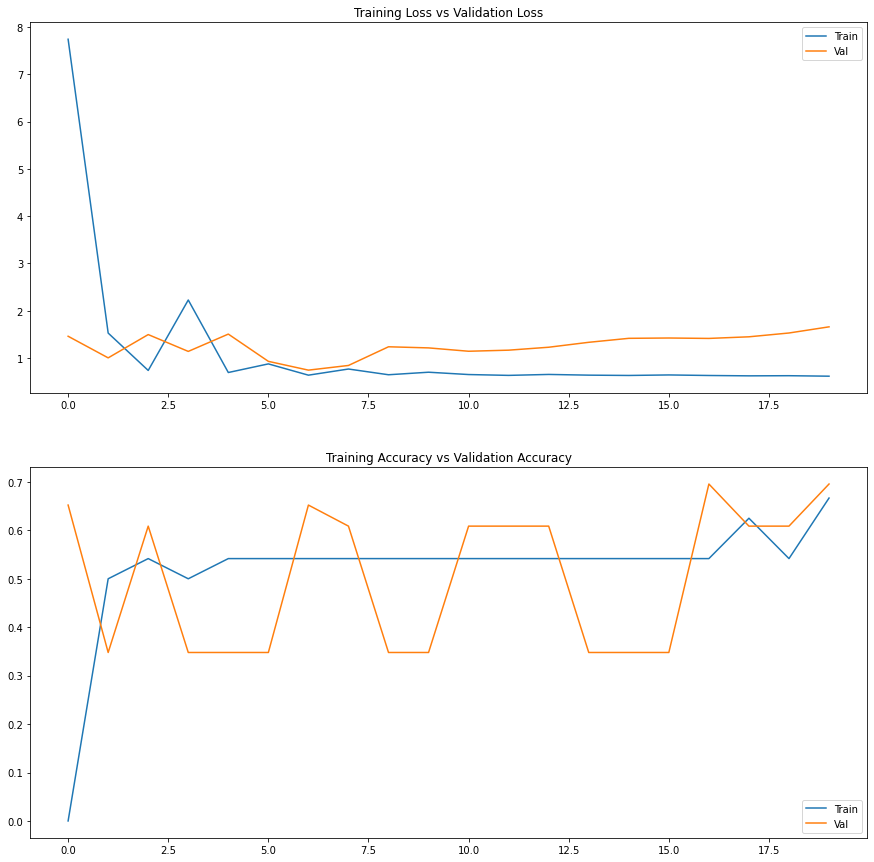

In [304]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
score = vgg16.evaluate(np.array(img_test, np.float32), df_img_dataset_test['label'].values)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
th_km = 0.05
y_pred = 2*(score["st_score"] > th_km)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix Simple Test, with normalization')